In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import tensorflow as tf
from keras import backend as K

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from glob import glob
import pickle

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import albumentations as albu

## 데이터 불러오기
* task   
임상 연구에 따르면 대장 내시경 검사 과정에서 용종 4개 중 1개는 놓치는 것으로 나타난다. 그 원인으로는 장시간의 연속적인 검사로 인한 눈의 피로와 주의력 부족이 있습니다.   
> object detection 및 segmentation을 통해 용종의 위치를 알려주어 의사의 용종 누락률과 그에 따른 대장암 사망률을 줄이는 것이 목표입니다.

* data   
용종과 대장내시경 카메라 사이의 거리에 따라 다른 크기로 나타납니다.   
광원에 대한 용종의 위치에 따라 용종이 다른 색으로 보입니다.   
> augmentation 필요성

* 데이터셋 폴더 경로   

data/   
> train/
>> labels/ (612개 label 데이터)  
>> images/ (612개 이미 데이터)

> new_train/  ... 원본 이미지 주위에 테두리 제거한 이미지
>> new_labels/ (612개 label 데이터)  
>> new_images/ (612개 이미 데이터)

> test_png/
>> labels/ (300개 label 데이터)  
>> images/ (300개 이미지 데이터)

In [3]:
os.path.join(os.getcwd(),'drive/MyDrive/DLthon/polyp_segmentation')

'/content/drive/MyDrive/DLthon/polyp_segmentation'

학습 이미지 크기 :  (264, 312, 3)
라벨 이미지 크기 :  (264, 312)
[0. 1.]


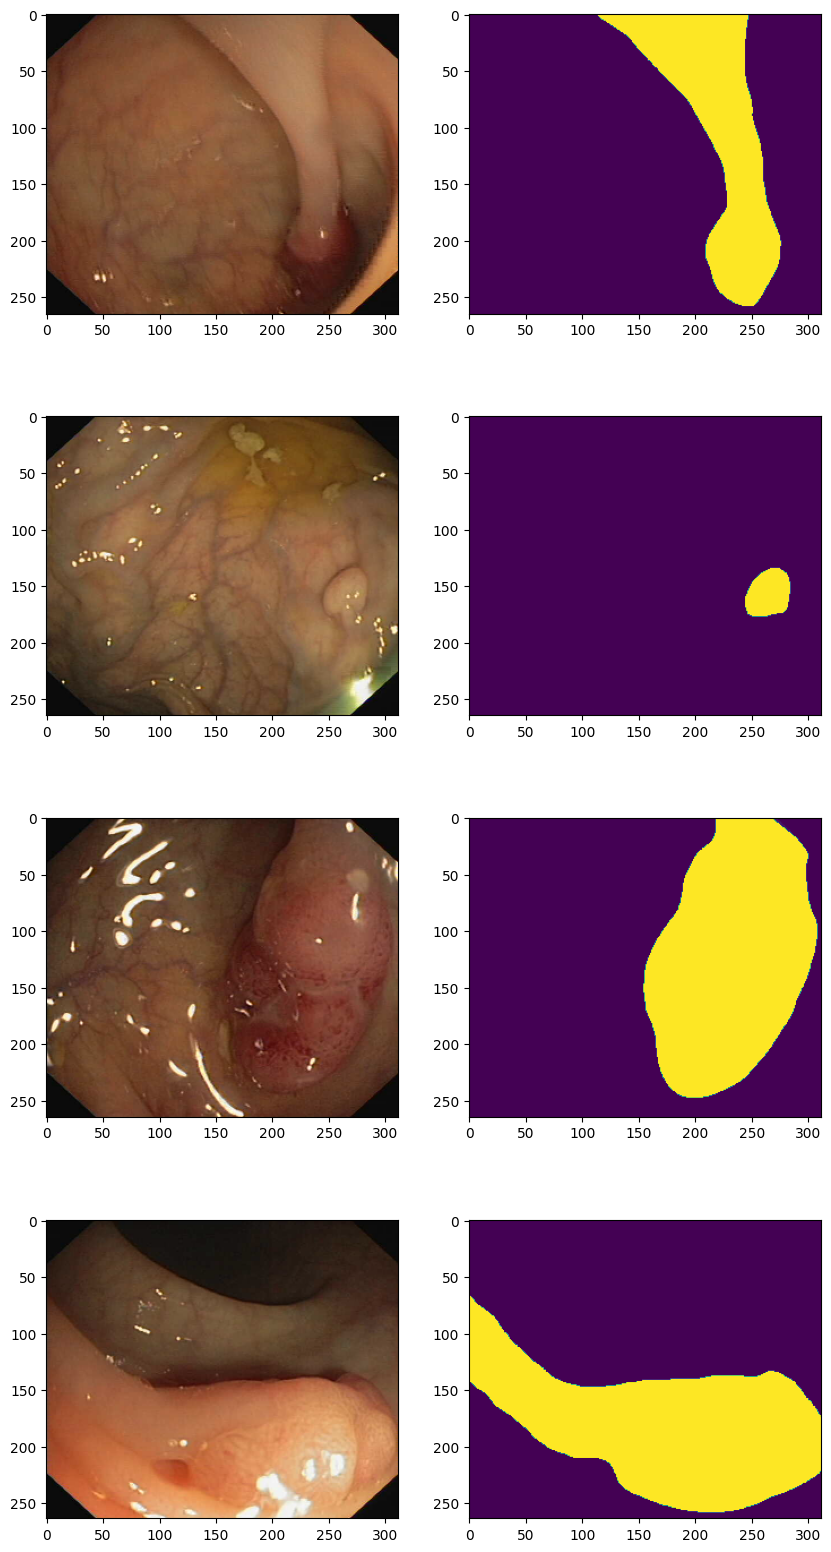

In [4]:
dir_path = os.path.join(os.getcwd(),'drive/MyDrive/DLthon/polyp_segmentation')

input_images = glob(os.path.join(dir_path, "new_train/new_images", "*.png"))
input_labels = glob(os.path.join(dir_path, "new_train/new_labels", "*.png"))

assert len(input_images) == len(input_labels) # 입력과 라벨의 개수가 일치하는가 확인

plt.figure(figsize=(10, 20))
for i in range(4):
    n = np.random.randint(len(input_images))
    image = imread(input_images[n])
    label = imread(input_labels[n], as_gray=True)

    plt.subplot(4, 2, 2*i+1)
    plt.imshow(image)  # 왼쪽이 원본이미지
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(label)  # 오른쪽이 augment된 이미지

print('학습 이미지 크기 : ',image.shape)
print('라벨 이미지 크기 : ',label.shape)
print(np.unique(label))

## Augmentation
albumentations 라이브러리를 이용하여 Augmentation진행

In [5]:
def build_augmentation(width=225, height=225,is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return albu.Compose([
                          albu.HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                          albu.VerticalFlip(p=0.5),     # 50%의 확률로 상하대칭
                          albu.ColorJitter(brightness=(0.6,1.6),  # 밝기를 0.6부터 1.6 사이에서 무작위로 조정
                                          contrast=0.2, # 대비를 0.2로 조정
                                          saturation=0.1,  # 채도를 0.1로 조정
                                          hue=0.01, # 색조를 0.01로 조정
                                          always_apply=True),
                          albu.Affine(scale=(0.5,1.5), # 크기를 0.5부터 1.5 사이에서 무작위로 조정
                                      translate_percent=(-0.125,0.125), # 좌우, 상하로 -0.125부터 0.125 사이에서 무작위로 이동
                                      rotate=(-180,180),  # -180도부터 180도 사이에서 무작위로 회전
                                      shear=(-22.5,22),  # -22.5부터 22.5 사이에서 무작위로 기울기 조정
                                      always_apply=True),
                          albu.Resize(              # 입력이미지를 224X224로 resize
                              width=width,
                              height=height
                              )
                      ])

    return albu.Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                    albu.Resize(
                          width=width,
                          height=height
                          )
                    ])

### Augmentation 확인

훈련 데이터 개수 612


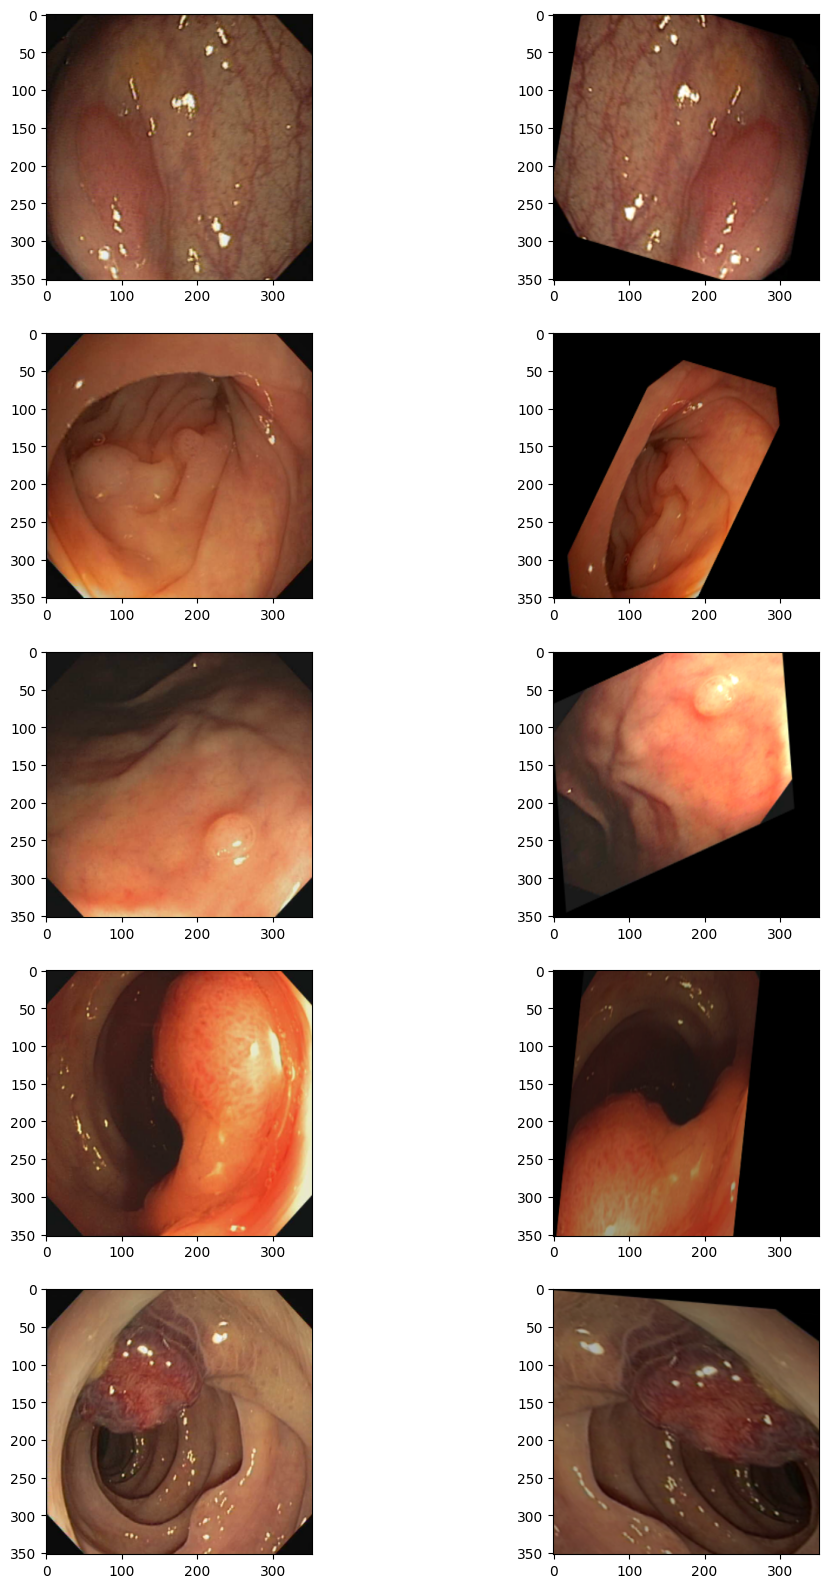

In [6]:
augmentation_train = build_augmentation(width=352, height=352,)
augmentation_test = build_augmentation(width=352, height=352,is_train=False)

print('훈련 데이터 개수',len(input_images))

# 훈련 데이터셋에서 랜덤한 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    n = np.random.randint(len(input_images))
    image = imread(input_images[n])
    image_data = {"image":image}

    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)

    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

## DataGenerator

In [7]:
class DatasetGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 Dataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                   dir_path,
                   batch_size=16,
                   img_size=(224, 224, 3),
                   output_size=(224, 224),
                   is_train=True,
                   augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size 입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train
        self.augmentation = augmentation

        # load_dataset()을 통해서 dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()


    def load_dataset(self):
        # dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 validation set을 분리해서 load하도록 해야합니다.
        # glob(dir) dir의 조건과 일치하는 파일명 전부 불러오기
        input_images = glob(os.path.join(self.dir_path, "new_train/new_images", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "new_train/new_labels", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images) # 입력과 라벨의 개수가 일치하는가 확인
        # 데이터 이미지와 라벨 묶기
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-50] # 훈련집합이면 뒤 50개을 제외한 562개를 return

        return data[-50:] # 검증 집합은 50개

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size] # 배치 단위로 잘라준다.

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path, as_gray=True) # , as_gray=True
            data = {
                  "image": _input,
                  "mask": _output,
                  }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [8]:
augmentation = build_augmentation(width=352, height=352)
test_preproc = build_augmentation(width=352, height=352,is_train=False)

train_generator = DatasetGenerator(
    dir_path,
    img_size=(352, 352, 3),
    output_size=(352, 352),
    augmentation=augmentation,
)

test_generator = DatasetGenerator(
    dir_path,
    img_size=(352, 352, 3),
    output_size=(352, 352),
    augmentation=test_preproc,
    is_train=False
)

## 모델 불러오기

In [ ]:
pip install keras_cv_attention_models

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/DLthon')

print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/DLthon']


### 모델 구조 불러오기

In [11]:
# 모델 구조 불러오기
from DUCK_Net import create_model
from U_Net import create_unet
from U_Netplusplus import create_unetpp

from DiceMetric import dice_metric_loss

# # U_net 모델
# model = create_unet(img_height = 224,
#                     img_width = 224,
#                     input_chanels = 3,
#                     out_classes = 1,
#                     starting_filters = 32)
# # U_net++ 모델
# model = create_unetpp(img_height = 224,
#                      img_width = 224,
#                      input_chanels = 3,
#                      out_classes = 1,
#                      starting_filters = 32)
# # DUCK_Net 모델
# model = create_model(img_height = 224,
#                      img_width = 224,
#                      input_chanels = 3,
#                      out_classes = 1,
#                      starting_filters = 32)



### pretrain 모델 불러오기

In [12]:
# Duck-Net17
ducknet17_path = os.path.join("/content/drive/MyDrive/DLthon/DuckNet17")
ducknet17_model = tf.keras.models.load_model(ducknet17_path,custom_objects={"dice_metric_loss": dice_metric_loss})

# # Duck-Net34
ducknet34_path = os.path.join("/content/drive/MyDrive/DLthon/DuckNet34")
ducknet34_model = tf.keras.models.load_model(ducknet34_path,custom_objects={"dice_metric_loss": dice_metric_loss})

## 결과 시각화 및 IoU 확인

![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/f6e3e60c-800d-4c66-9495-0437907e7819)

1. Loss >> 병변을 놓치지 않고 검출해야하는 의료 환경 특성에 맞춰, 양성데이터를 음성으로 판단하는 것을 최소한으로 설정하기 위해 Dice coefficient loss를 사용(세번째그림)
2. Metric >> IoU와 Dice 서로 양의 상관관계에 있기 때문에 아무거나 사용해도 되지만, 더 직관적으로 해석 가능한 IoU를 metric 으로 사용



In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = (intersection / union).astype(np.float32)
    return iou_score

In [14]:
def get_output(model,
               preproc,
               image_path,
               label_path,
               threshold=0.5,
               is_show = True):

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=threshold).astype(np.uint8).squeeze(-1)*255
    prediction = output/255

    if is_show:
        output = Image.fromarray(output)
        background = Image.fromarray(origin_img).convert('RGBA')
        output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
        output = Image.blend(background, output, alpha=0.5)

    if label_path:
        label_img = imread(label_path, as_gray=True)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        target = label_processed["image"].astype(np.uint8)

        iou_score = calculate_iou_score(target, prediction)

        return output, prediction, target, iou_score
    else:
        return output, prediction, _

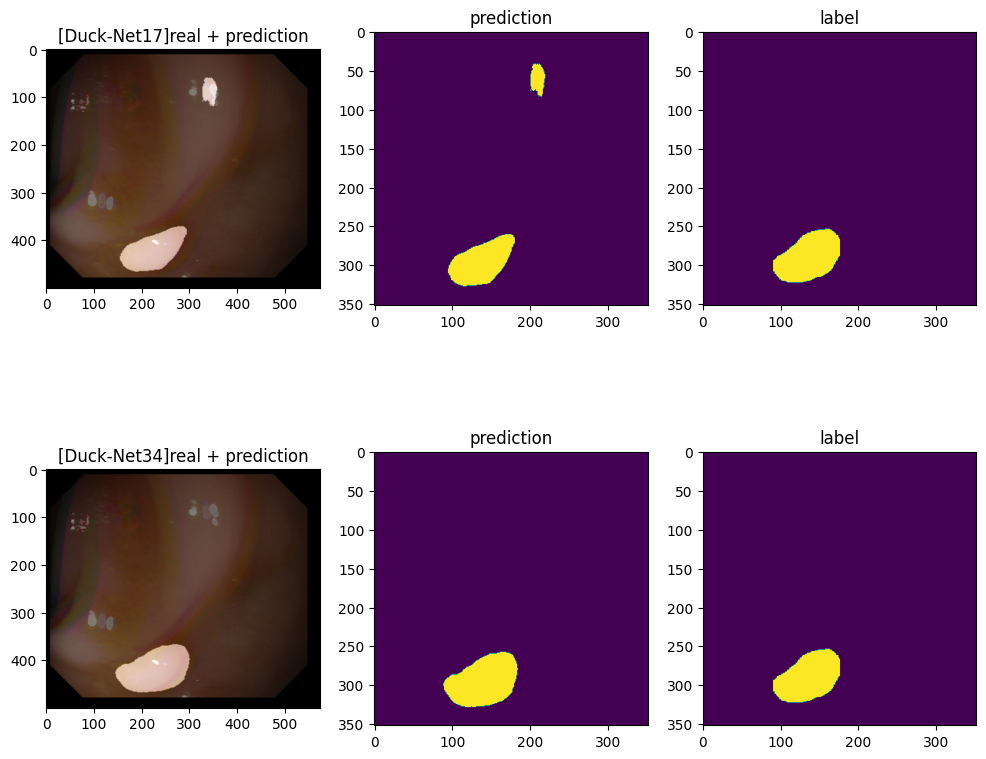

[Duck-Net17] IoU : 0.630721
[Duck-Net34] IoU : 0.731091


In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4 # i값을 바꾸면 테스트용 파일이 달라집니다.

plt.figure(figsize=(12,10))
output, prediction, target,iou_score17 = get_output(
     ducknet17_model,
     test_preproc,
     image_path=dir_path + f'/test_png/images/{str(i)}.png',
     label_path=dir_path + f'/test_png/labels/{str(i)}.png',
     threshold=0.5)


plt.subplot(2,3,1)
plt.imshow(output)
plt.title("[Duck-Net17]real + prediction")
plt.subplot(2,3,2)
plt.imshow(prediction)
plt.title("prediction")
plt.subplot(2,3,3)
plt.imshow(target)
plt.title("label")


output, prediction, target,iou_score34 = get_output(
     ducknet34_model,
     test_preproc,
     image_path=dir_path + f'/test_png/images/{str(i)}.png',
     label_path=dir_path + f'/test_png/labels/{str(i)}.png',
     threshold=0.5)

plt.subplot(2,3,4)
plt.imshow(output)
plt.title("[Duck-Net34]real + prediction")
plt.subplot(2,3,5)
plt.imshow(prediction)
plt.title("prediction")
plt.subplot(2,3,6)
plt.imshow(target)
plt.title("label")
plt.show()
print('[Duck-Net17] IoU : %f' % iou_score17 )
print('[Duck-Net34] IoU : %f' % iou_score34 )

# 루브릭 1)
* 모델의 성능을 정량적으로 평가하였는가?
  * Segmentation 모델의 성능을 IOU 기준 0.7 이상으로 달성하기



In [16]:
iou_scores17 = []
iou_scores34 = []
for i in range(1,301):
    _, _, _,iou_score17 = get_output(
         ducknet17_model,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(i)}.png',
         label_path=dir_path + f'/test_png/labels/{str(i)}.png',
         threshold=0.5,
         is_show = False
     )
    iou_scores17.append(iou_score17)
    _, _, _,iou_score34 = get_output(
         ducknet34_model,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(i)}.png',
         label_path=dir_path + f'/test_png/labels/{str(i)}.png',
         threshold=0.5,
         is_show = False
     )
    iou_scores34.append(iou_score34)
print('[Duck-Net17] mean IoU :%f' % np.mean(iou_scores17))
print('[Duck-Net34] mean IoU :%f' % np.mean(iou_scores34))

[Duck-Net17] mean IoU :0.665800
[Duck-Net34] mean IoU :0.715841


# 루브릭 2)
* 모델이 예측한 결과물에 대해 정성적으로 분석하였는가?
  * 모델의 출력 결과를 케이스 별로 구분하고, 특이점에 대한 관찰 결과를 정리하여 학습 전략을 도출하기



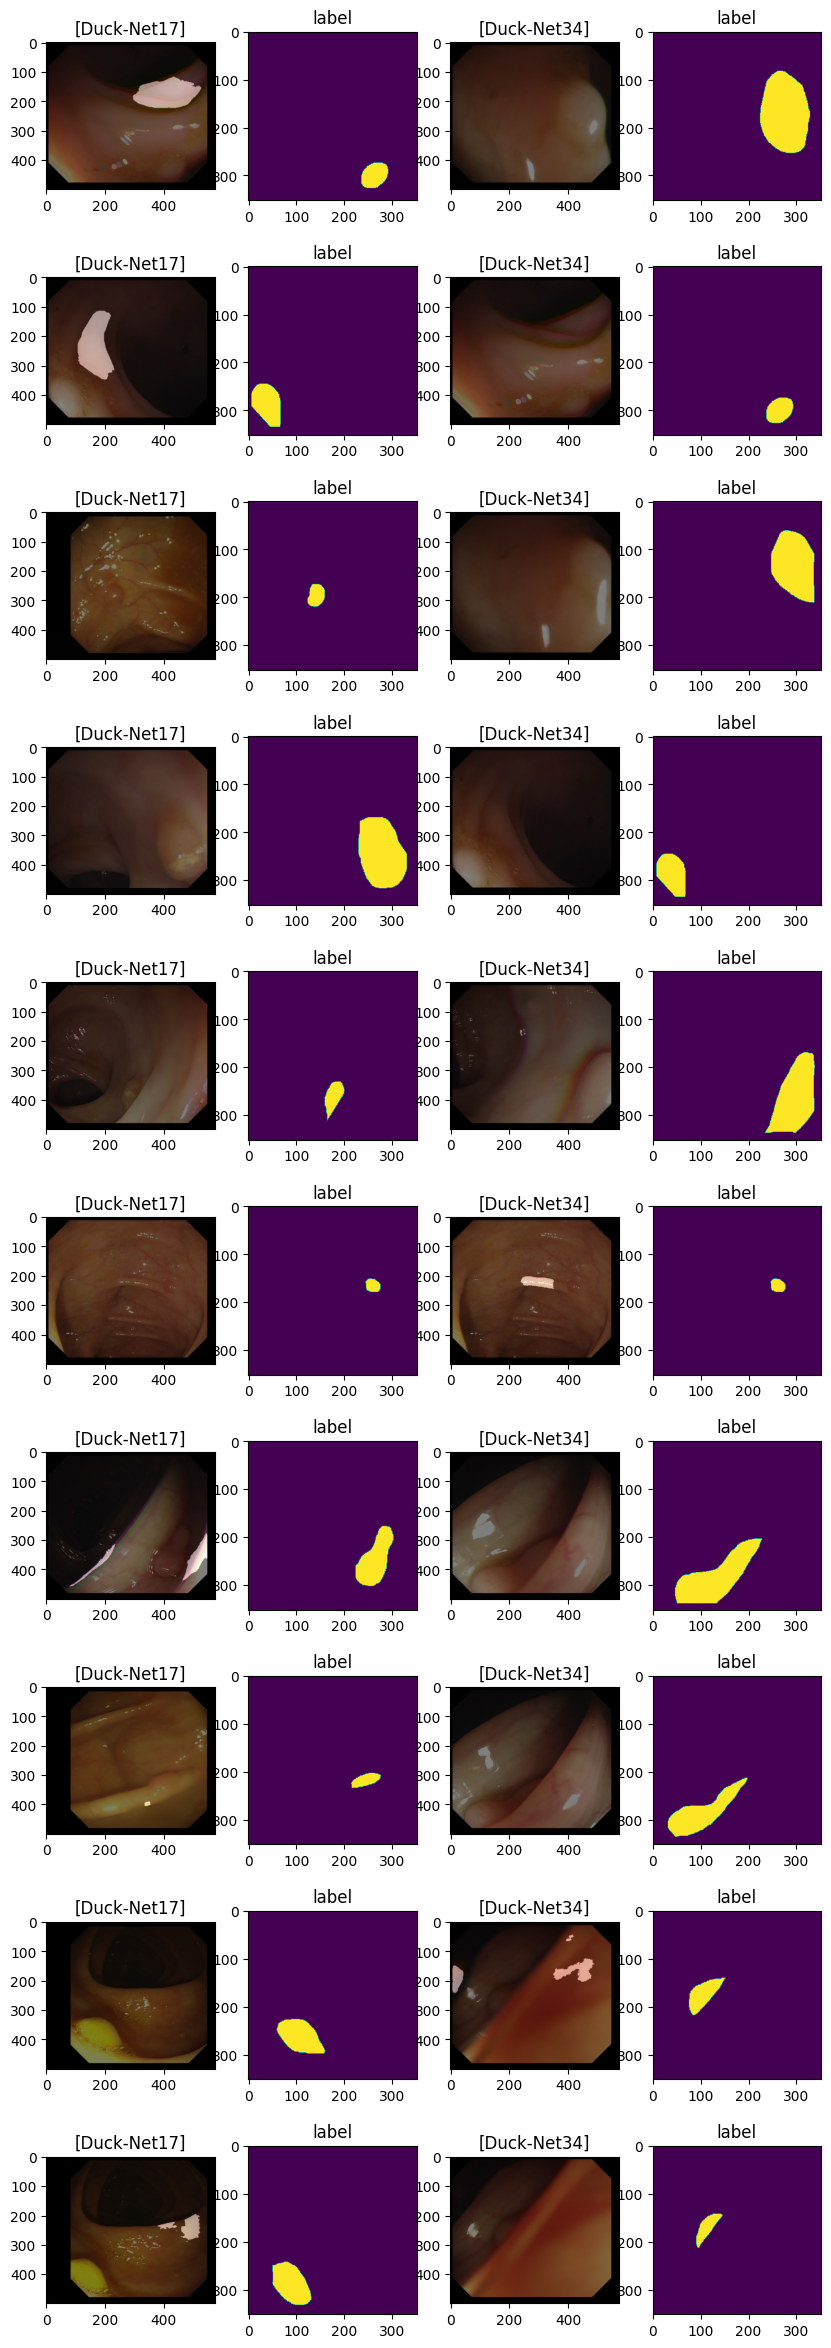

In [17]:
iou_scores17_zero = [index for index, value in enumerate(iou_scores17) if value == 0.0]
iou_scores34_zero = [index for index, value in enumerate(iou_scores34) if value == 0.0]

N = 10
plt.figure(figsize=(N,30))
for i in range(10):
  n17 = iou_scores17_zero[i]
  n34 = iou_scores34_zero[i]

  output17, _,target,_ = get_output(
         ducknet17_model,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(n17+1)}.png',
         label_path=dir_path + f'/test_png/labels/{str(n17+1)}.png',
         threshold = 0.5)

  plt.subplot(10,4,i*4 + 1)
  plt.imshow(output17)
  plt.title("[Duck-Net17]")
  plt.subplot(10,4,i*4 + 2)
  plt.imshow(target)
  plt.title("label")

  output34, _,target,_ = get_output(
         ducknet34_model,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(n34+1)}.png',
         label_path=dir_path + f'/test_png/labels/{str(n34+1)}.png',
         threshold = 0.5)

  plt.subplot(10,4,i*4 + 3)
  plt.imshow(output34)
  plt.title("[Duck-Net34]")
  plt.subplot(10,4,i*4 + 4)
  plt.imshow(target)
  plt.title("label")
plt.show()

위 이미지는 IoU가 낮은 이미지를 모아서 나타낸것이다.   
전체적으로 찾기 어려워 보이는 이미지들로 구성되어 있다. 대부분 어둡거나 빛의 반사가 있는 것을 볼 수 있다.   

이미지의 노출되는 빛을 제거해주는 방법을 제안한다.   
[Homomorphic Filter](https://ausome.tistory.com/5)   
[[OpenCV] 조명(Lighting)의 영향을 제거](https://t9t9.com/60)

# 루브릭 3)
* 기계 학습을 통해 문제 해결 방법론과 자원 확보 전략을 확장할 수 있는가?
  * Polyp 탐지에서 segmentation label 이 없거나, object detection 와 같이 낮은 차원의 label 만 있을 경우, 모델의 성능을 표현할 방법과 이에 맞는 학습 전략을 기획하여 제시하기



### Semi-supervised Learning (준지도 학습)
데이터를 라벨링하거나 학습 데이터를 만드는 것은 매우 큰 비용이 필요하다.   
준지도 학습은 레이블이 있는 데이터와 없는 데이터를 동시에 사용하는 모델을 만드는 것이다.  
이러한 방법은 매니폴드 가정에 의해서 라벨이 없는 데이터 또한 결정을 할 수 있게 됩니다.   



# U-Net VS U-Net++


In [18]:
model_path = '/content/drive/MyDrive/DLthon/model_save'
# U-Net 불러오기
model_unet = tf.keras.models.load_model(os.path.join(model_path,'model_aug_unet_epo200.h5'),custom_objects={"dice_metric_loss": dice_metric_loss})
with open(os.path.join(model_path,'hist_aug_unet_epo200'), "rb") as file_pi:
    history_unet = pickle.load(file_pi)

# U-Net++ 불러오기
model_unetpp = tf.keras.models.load_model(os.path.join(model_path,'model_aug_unetpp_epo200_final.h5'),custom_objects={"dice_metric_loss": dice_metric_loss})
with open(os.path.join(model_path,'hist_aug_unetpp_epo200_final'), "rb") as file_pi:
    history_unetpp = pickle.load(file_pi)

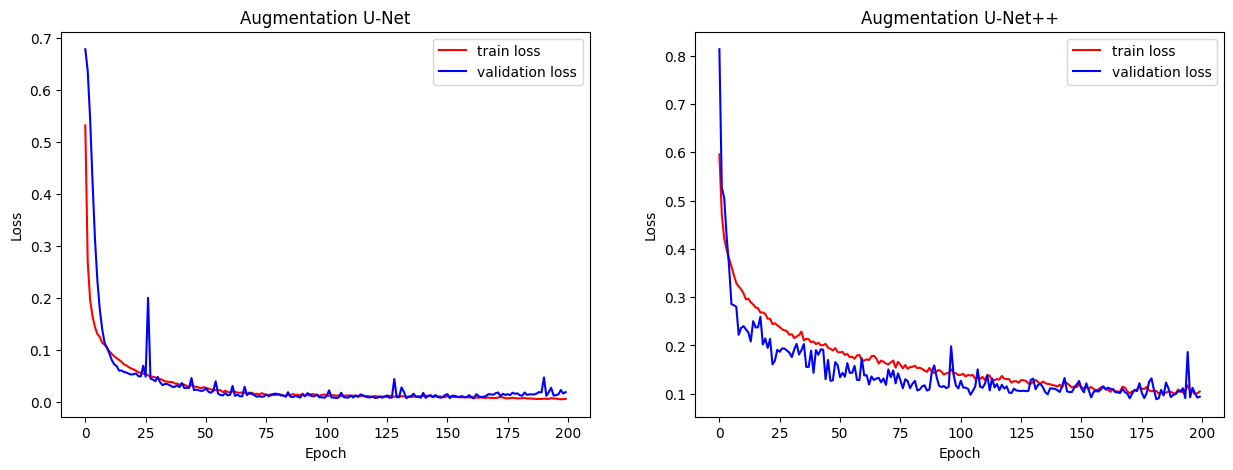

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_unet['loss'], 'r',history_unet['val_loss'], 'b')
plt.title('Augmentation U-Net')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_unetpp['loss'], 'r',history_unetpp['val_loss'], 'b')
plt.title('Augmentation U-Net++')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')


plt.show()

In [20]:
test_preproc = build_augmentation(width=224, height=224,is_train=False)

test_generator = DatasetGenerator(
    dir_path,
    img_size=(224, 224, 3),
    output_size=(224, 224),
    augmentation=test_preproc,
    is_train=False
)

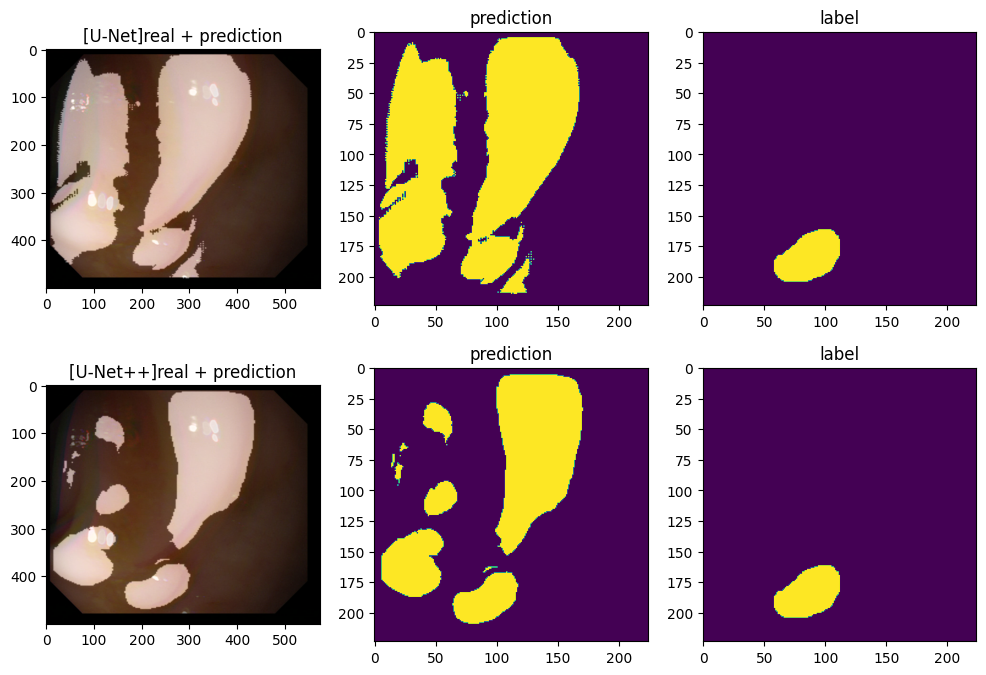

[U-Net] IoU : 0.058600
[U-Net++] IoU : 0.090581


In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4 # i값을 바꾸면 테스트용 파일이 달라집니다.

plt.figure(figsize=(12,8))
output, prediction, target,iou_score_unet = get_output(
     model_unet,
     test_preproc,
     image_path=dir_path + f'/test_png/images/{str(i)}.png',
     label_path=dir_path + f'/test_png/labels/{str(i)}.png',
     threshold=0.5)

plt.subplot(2,3,1)
plt.imshow(output)
plt.title("[U-Net]real + prediction")
plt.subplot(2,3,2)
plt.imshow(prediction)
plt.title("prediction")
plt.subplot(2,3,3)
plt.imshow(target)
plt.title("label")


output, prediction, target,iou_score_unetpp = get_output(
     model_unetpp,
     test_preproc,
     image_path=dir_path + f'/test_png/images/{str(i)}.png',
     label_path=dir_path + f'/test_png/labels/{str(i)}.png',
     threshold=0.5)

plt.subplot(2,3,4)
plt.imshow(output)
plt.title("[U-Net++]real + prediction")
plt.subplot(2,3,5)
plt.imshow(prediction)
plt.title("prediction")
plt.subplot(2,3,6)
plt.imshow(target)
plt.title("label")
plt.show()
print('[U-Net] IoU : %f' % iou_score_unet )
print('[U-Net++] IoU : %f' % iou_score_unetpp )

In [22]:
iou_unet = []
iou_unetpp = []
for i in range(1,301):
    _, _, _,iou_score_unet = get_output(
         model_unet,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(i)}.png',
         label_path=dir_path + f'/test_png/labels/{str(i)}.png',
         threshold=0.5,
         is_show = False
     )
    iou_unet.append(iou_score_unet)

    _, _, _,iou_score_unetpp = get_output(
         model_unetpp,
         test_preproc,
         image_path=dir_path + f'/test_png/images/{str(i)}.png',
         label_path=dir_path + f'/test_png/labels/{str(i)}.png',
         threshold=0.5,
         is_show = False
     )
    iou_unetpp.append(iou_score_unetpp)
print('[U-Net] mean IoU :%f' % np.mean(iou_unet))
print('[U-Net++] mean IoU :%f' % np.mean(iou_unetpp))

[U-Net] mean IoU :0.105031
[U-Net++] mean IoU :0.404334


## 동익님의 Pretrain

![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/ae2ddf5c-97f5-4a65-97eb-dba995740543)

ducknet17 pretrain   

iou 평균 0.89  